In [103]:
# Library imports.
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from pathlib import Path

# UrbanSurge imports.
from urbansurge.swmm_model import SWMM
from urbansurge.analysis_tools import perturb_storm_arrival, perturb_storm_magnitude, split_storms, combine_storms, generate_runoff
from urbansurge.data_acquisition import flow_to_swmm_readable

# Autoreload.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Configurations

In [104]:
# File directory for saving figures.
fig_savefp = Path(r'C:\Users\ay434\Box\Research\Smart_Stormwater\Paper_3\Figures')

# Colorscheme.
cNF = '#d6977e'
cF = '#9cc4b2'

## Runoff

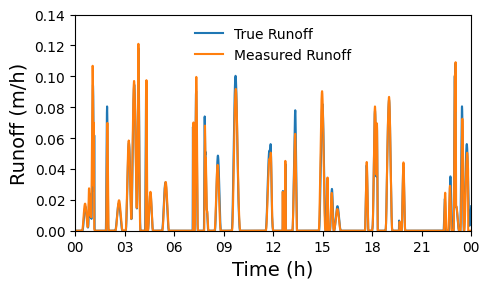

In [176]:
# Generate runoff time series.
dt = 10
T = 1
n_pulse = 50
a_bounds = (0.001, 0.1)
L_bounds = (60, 60 * 30)
sig_a = 0.0
sig_L = 0
sig_imp = 0
n_runoff = 1
seed = 10
R1, t = generate_runoff(dt, T, n_pulse, a_bounds, L_bounds, sig_a, sig_L, sig_imp, n_runoff, seed)

# Measurement of runoff.
sig_t = 60 * 10
sig_m = 0.1
S, St = split_storms(R1, t)
Sp, Stp = perturb_storm_arrival(S, St, t, sig_t)
Sp, Stp = perturb_storm_magnitude(Sp, Stp, t, sig_m)
R1m = combine_storms(Sp, Stp, t)

# Time as a datetime object.
t_datetime = [datetime(2020, 1, 1) + timedelta(seconds=i) for i in t]

fig, ax = plt.subplots(figsize=(5,3))
ax.plot(t_datetime, R1, label='True Runoff')
ax.plot(t_datetime, R1m, label='Measured Runoff')
ax.set_xlabel('Time (h)', fontsize=14)
ax.set_ylabel('Runoff (m/h)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=10)
myFmt = mdates.DateFormatter('%H')
ax.xaxis.set_major_formatter(myFmt)
ax.set_xlim([t_datetime[0], t_datetime[-1] + timedelta(seconds=10)]) 
ax.set_ylim([0, 0.14]) 
ax.legend(frameon=False)   
fig.tight_layout()

### Save runoff into SWMM files

In [177]:
# Impulse directory.
impulse_dir_P = Path(r'C:\Users\ay434\Documents\urbansurge\analysis\lab_system\precipitation\precip_data\paper3_exp')

# Impulse files corresponding to each node. {Node: Impulse filename}
impulse_files_P = {
    '46': 'R46',
    '44': 'R44',
    '42': 'R42',
    '40': 'R40',
    '38': 'R38',
}

for node, fname in impulse_files_P.items():
    flow_to_swmm_readable(R1.flatten(), t_datetime, impulse_dir_P, f'{fname}.dat')

## SWMM model

In [178]:
# SWMM model configuration file. 
config_path = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\lab_weirs_config.yml"

# Create instance of SWMM model.
swmm = SWMM(config_path)

# Configure model.
swmm.configure_model()

# Run model.
swmm.run_simulation()

Simulation info
Flow Units: CFS
System Units: US
Start Time: 2020-01-01 00:00:00
Start Time: 2020-01-02 06:00:00
INP PATH: C:\Users\ay434\Documents\urbansurge\analysis\lab_system\lab_weirs_tmp.inp
2020-01-01 00:00:01 , 0
2020-01-01 00:16:41 , 1
2020-01-01 00:33:21 , 2
2020-01-01 00:50:01 , 3
2020-01-01 01:06:41 , 4
2020-01-01 01:23:21 , 5
2020-01-01 01:40:01 , 6
2020-01-01 01:56:41 , 6
2020-01-01 02:13:21 , 7
2020-01-01 02:30:01 , 8
2020-01-01 02:46:41 , 9
2020-01-01 03:03:21 , 10
2020-01-01 03:20:01 , 11
2020-01-01 03:36:41 , 12
2020-01-01 03:53:21 , 13
2020-01-01 04:10:01 , 14
2020-01-01 04:26:41 , 15
2020-01-01 04:43:21 , 16
2020-01-01 05:00:01 , 17
2020-01-01 05:16:41 , 18
2020-01-01 05:33:21 , 19
2020-01-01 05:50:01 , 19
2020-01-01 06:06:41 , 20
2020-01-01 06:23:21 , 21
2020-01-01 06:40:01 , 22
2020-01-01 06:56:41 , 23
2020-01-01 07:13:17 , 24
2020-01-01 07:29:57 , 25
2020-01-01 07:46:37 , 26
2020-01-01 08:03:17 , 27
2020-01-01 08:19:57 , 28
2020-01-01 08:36:37 , 29
2020-01-01 08:

## Peak timing

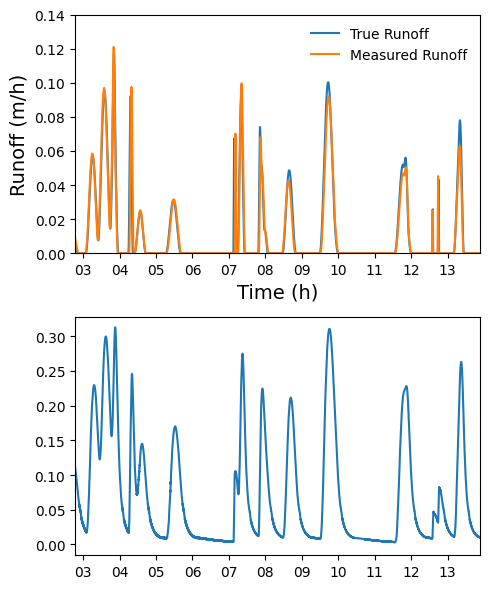

In [179]:
# Depth data.
depth_data = swmm.get_link_depth()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,6))
ax1.plot(t_datetime, R1, label='True Runoff')
ax1.plot(t_datetime, R1m, label='Measured Runoff')
ax1.set_xlabel('Time (h)', fontsize=14)
ax1.set_ylabel('Runoff (m/h)', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=10)
myFmt = mdates.DateFormatter('%H')
ax1.xaxis.set_major_formatter(myFmt)
ax1.set_xlim([t_datetime[1000], t_datetime[5000]]) 
ax1.set_ylim([0, 0.14]) 
ax1.legend(frameon=False)   

ax2.plot(depth_data['datetime'], depth_data['Depth_link_18'])
ax2.set_xlim([t_datetime[1000], t_datetime[5000]]) 
myFmt = mdates.DateFormatter('%H')
ax2.xaxis.set_major_formatter(myFmt)

fig.tight_layout()

In [180]:
# Run model with measured data.
for node, fname in impulse_files_P.items():
    flow_to_swmm_readable(R1m.flatten(), t_datetime, impulse_dir_P, f'{fname}.dat')

# Run model.
swmm.run_simulation()

# Depth data.
sim_depth_data = swmm.get_link_depth()

INP PATH: C:\Users\ay434\Documents\urbansurge\analysis\lab_system\lab_weirs_tmp.inp
2020-01-01 00:00:01 , 0
2020-01-01 00:16:41 , 1
2020-01-01 00:33:21 , 2
2020-01-01 00:50:01 , 3
2020-01-01 01:06:41 , 4
2020-01-01 01:23:21 , 5
2020-01-01 01:40:01 , 6
2020-01-01 01:56:41 , 6
2020-01-01 02:13:21 , 7
2020-01-01 02:30:01 , 8
2020-01-01 02:46:41 , 9
2020-01-01 03:03:21 , 10
2020-01-01 03:20:01 , 11
2020-01-01 03:36:41 , 12
2020-01-01 03:53:21 , 13
2020-01-01 04:10:01 , 14
2020-01-01 04:26:41 , 15
2020-01-01 04:43:21 , 16
2020-01-01 05:00:01 , 17
2020-01-01 05:16:41 , 18
2020-01-01 05:33:21 , 19
2020-01-01 05:50:01 , 19
2020-01-01 06:06:41 , 20
2020-01-01 06:23:21 , 21
2020-01-01 06:40:01 , 22
2020-01-01 06:56:41 , 23
2020-01-01 07:13:17 , 24
2020-01-01 07:29:57 , 25
2020-01-01 07:46:37 , 26
2020-01-01 08:03:17 , 27
2020-01-01 08:19:57 , 28
2020-01-01 08:36:37 , 29
2020-01-01 08:53:17 , 30
2020-01-01 09:09:57 , 31
2020-01-01 09:26:37 , 31
2020-01-01 09:43:17 , 32
2020-01-01 09:59:57 , 33
20

In [181]:
import numpy as np
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from scipy.signal import find_peaks

def average_peak_timing_difference(R: np.ndarray, depth: np.ndarray, dt) -> float:
    """
    Finds the average difference in peak timing between two numpy arrays using dynamic time warping.

    :param R: Measured runoff time series.
    :type R: np.ndarray
    :param depth: Depth time series measured at the outlet of a stormwater system.
    :type depth: np.ndarray
    :return: Average difference in peak timing.
    :rtype: float
    """
    # Use dynamic time warping to align the peaks
    Rnorm = (R - np.mean(R)) / np.std(R)
    dnorm = (depth - np.mean(depth)) / np.std(depth)

    peaks_R = find_peaks(Rnorm, prominence=np.max(Rnorm) / 10)[0]
    peaks_d = find_peaks(dnorm, prominence=np.max(dnorm) / 10)[0]

    # # Method 1: find peaks first.
    # _, path = fastdtw(peaks_R, peaks_d, dist=2)
    # peaks_path = dict(path)
    # peaks_relation = {peaks_R[i]: peaks_d[j] for i, j in peaks_path.items()}

    # Method 2: find peaks after DTW.
    _, path = fastdtw(Rnorm, dnorm, dist=2, radius=2)
    path = dict(path)
    peaks_relation = {i: path[i] for i in peaks_R}

    # Calculate the average difference in peak timing
    peak_differences = np.array([(j - i) * dt for i, j in peaks_relation.items()])
    # average_difference = np.mean(peak_differences)

    return peaks_relation, peak_differences, Rnorm, dnorm, path

R = R1.flatten()
peaks_relation, peak_differences, Rnorm, dnorm, path = average_peak_timing_difference(depth_data['Depth_link_18'], sim_depth_data['Depth_link_18'].to_numpy().flatten(), dt)

55.625


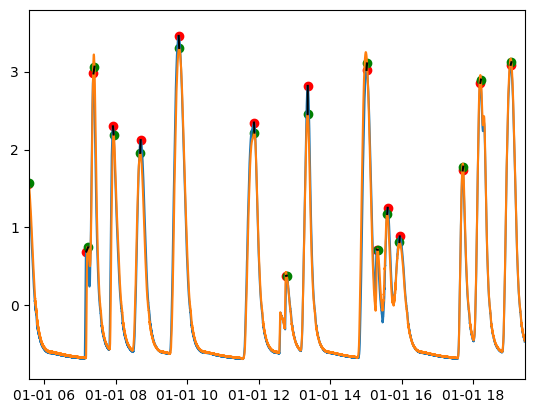

In [184]:
print(np.mean(peak_differences))

fig, ax = plt.subplots()
ax.plot(depth_data['datetime'], Rnorm)
ax.scatter([depth_data.loc[i, 'datetime'] for i in peaks_relation.keys()], [Rnorm[i] for i in peaks_relation.keys()], color='red')
ax.plot(depth_data['datetime'], dnorm)
ax.scatter([depth_data.loc[i, 'datetime'] for i in peaks_relation.values()], 
            [dnorm[i] for i in peaks_relation.values()], color='green')
# for i in path.keys():
#     ax.plot([depth_data.loc[i, 'datetime'], depth_data.loc[path[i], 'datetime']], [Rnorm[i], dnorm[path[i]]], alpha=0.25, color='black')
for i in peaks_relation.keys():
    ax.plot([depth_data.loc[i, 'datetime'], depth_data.loc[peaks_relation[i], 'datetime']], 
            [Rnorm[i], dnorm[peaks_relation[i]]], color='black')
n = 2000
ax.set_xlim([t_datetime[n], t_datetime[n + 5000]]) 
myFmt = mdates.DateFormatter('%H')
ax2.xaxis.set_major_formatter(myFmt)

# fig, ax = plt.subplots()
# peaks_d = find_peaks(dnorm, prominence=np.max(dnorm) / 10)[0]
# ax.plot(dnorm)
# # ax.set_xlim([t_datetime[1000], t_datetime[1100]]) 
# ax.scatter(peaks_d, dnorm[peaks_d], color='red')

# fig, ax = plt.subplots()
# peaks_R = find_peaks(Rnorm)[0]
# ax.plot(Rnorm)
# ax.scatter(peaks_R, Rnorm[peaks_R], color='red')


(array([1., 0., 2., 1., 0., 2., 1., 0., 5., 3., 7., 3., 2., 2., 0., 0., 1.,
        0., 1., 0., 1.]),
 array([-90.        , -75.23809524, -60.47619048, -45.71428571,
        -30.95238095, -16.19047619,  -1.42857143,  13.33333333,
         28.0952381 ,  42.85714286,  57.61904762,  72.38095238,
         87.14285714, 101.9047619 , 116.66666667, 131.42857143,
        146.19047619, 160.95238095, 175.71428571, 190.47619048,
        205.23809524, 220.        ]),
 <BarContainer object of 21 artists>)

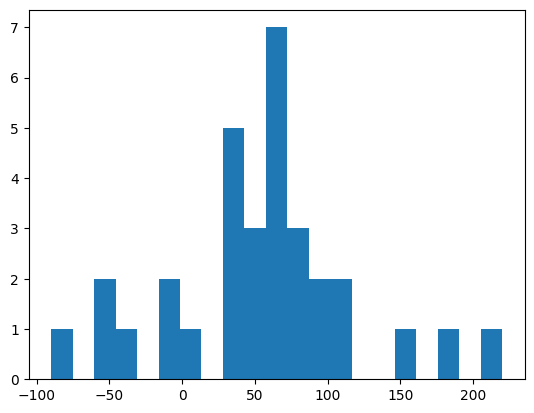

In [183]:
fig, ax = plt.subplots()
ax.hist(peak_differences, bins=21)